# Part 1 - Finding Key Connectors

Given a list of users and their friendships, find the users who have the most friends in common

In [1]:
users = [
    { "id": 0, "name": "Hero" },
    { "id": 1, "name": "Dunn" },
    { "id": 2, "name": "Sue" },
    { "id": 3, "name": "Chi" },
    { "id": 4, "name": "Thor" },
    { "id": 5, "name": "Clive" },
    { "id": 6, "name": "Hicks" },
    { "id": 7, "name": "Devin" },
    { "id": 8, "name": "Kate" },
    { "id": 9, "name": "Klein" }
]

friendship_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

Having friendships represented as a list of pairs is not the easiest way to work with
them. To find all the friendships for user 1, you have to iterate over every pair looking
for pairs containing 1. If you had a lot of pairs, this would take a long time.
Instead, let’s create a dict where the keys are user ids and the values are lists of friend
ids. (Looking things up in a dict is very fast.)

In [2]:
# Initialize the dict with an empty list for each user id:
friendships = {user["id"]: [] for user in users}

# And then populate it with the friendships data:
for i, j in friendship_pairs:
    friendships[i].append(j) # Add j as a friend of user i
    friendships[j].append(i) # Add i as a friend of user j

print(friendships)

{0: [1, 2], 1: [0, 2, 3], 2: [0, 1, 3], 3: [1, 2, 4], 4: [3, 5], 5: [4, 6, 7], 6: [5, 8], 7: [5, 8], 8: [6, 7, 9], 9: [8]}


Now we can ask questions of our graph, like “what’s the average number of connections?”:

In [3]:
def number_of_friends(user):
    user_id = user["id"]
    friend_ids = friendships[user_id]
    return len(friend_ids)

total_connections = sum(number_of_friends(user) for user in users) # 24

num_users = len(users) # length of the users list # 10
avg_connections = total_connections / num_users 

print(avg_connections)

2.4


Find the most connected people

In [4]:
# Create a list (user_id, number_of_friends)
num_friends_by_id = [(user["id"], number_of_friends(user)) for user in users]

num_friends_by_id.sort( # Sort the list
    key=lambda id_and_friends: id_and_friends[1], # by num_friends
    reverse=True # largest to smallest
)

print(num_friends_by_id) # Each pair is (user_id, num_friends)

[(1, 3), (2, 3), (3, 3), (5, 3), (8, 3), (0, 2), (4, 2), (6, 2), (7, 2), (9, 1)]


# Part 2 - "Data Scientists You May Know" suggester

Create the function to iterate over friends and collect friends of friends.

In [5]:
def foaf_ids_bad(user):
    """foaf is short for 'friend of a friend' """
    return [foaf_id
            for friend_id in friendships[user["id"]]
            for foaf_id in friendships[friend_id]]

print(foaf_ids_bad(users[0]))

[0, 2, 3, 0, 1, 3]


Knowing that people are friends of friends in multiple ways seems like interesting
information, so maybe instead we should produce a count of mutual friends. And we
should probably exclude people already known to the user:

In [6]:
from collections import Counter

def friends_of_friends(user):
    user_id = user["id"]
    return Counter(
        foaf_id
        for friend_id in friendships[user_id] # For each of my friends
        for foaf_id in friendships[friend_id] # Find their friends
        if foaf_id != user_id # Who aren't me
        and foaf_id not in friendships[user_id] # And aren't my friends
    )

print(friends_of_friends(users[3]))

# This correctly tells Chi (id 3) that she has two mutual friends with Hero (id 0) but only one mutual friend with Clive (id 5).

Counter({0: 2, 5: 1})


As a data scientist, you know that you also might enjoy meeting users with similar
interests. (This is a good example of the “substantive expertise” aspect of data science.)
After asking around, you manage to get your hands on this data, as a list of
pairs (user_id, interest):

In [7]:
interests = [
    (0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"),
    (0, "Spark"), (0, "Storm"), (0, "Cassandra"),
    (1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"),
    (1, "Postgres"), (2, "Python"), (2, "scikit-learn"), (2, "scipy"),
    (2, "numpy"), (2, "statsmodels"), (2, "pandas"), (3, "R"), (3, "Python"),
    (3, "statistics"), (3, "regression"), (3, "probability"),
    (4, "machine learning"), (4, "regression"), (4, "decision trees"),
    (4, "libsvm"), (5, "Python"), (5, "R"), (5, "Java"), (5, "C++"),
    (5, "Haskell"), (5, "programming languages"), (6, "statistics"),
    (6, "probability"), (6, "mathematics"), (6, "theory"),
    (7, "machine learning"), (7, "scikit-learn"), (7, "Mahout"),
    (7, "neural networks"), (8, "neural networks"), (8, "deep learning"),
    (8, "Big Data"), (8, "artificial intelligence"), (9, "Hadoop"),
    (9, "Java"), (9, "MapReduce"), (9, "Big Data")
]

# For example, Hero (id 0) has no friends in common with Klein (id 9), but they share interests in Java and big data.
# It is easy to build a function that finds users with a certain interest:

def data_scientists_who_like(target_interest):
    return [user_id
            for user_id, user_interest in interests
            if user_interest == target_interest]

print(data_scientists_who_like("Java"))

[0, 5, 9]


This works, but it has to examine the whole list of interests for every search. If we
have a lot of users and interests (or if we just want to do a lot of searches), we’re probably
better off building an index from interests to users:

In [8]:
from collections import defaultdict

# Keys are interests, values are lists of user_ids with that interest
user_ids_by_interest = defaultdict(list)

for user_id, interest in interests:
    user_ids_by_interest[interest].append(user_id) # We get: {'Java': [0, 5, 9], 'Big Data': [0, 8, 9], ...}

# And another from users to interests
# Keys are user_ids, values are lists of interests for that user_id
interests_by_user_id = defaultdict(list)

for user_id, interest in interests:
    interests_by_user_id[user_id].append(interest) # We get: {0: ['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra'], ...}

Now it's easy to find who has the most interests in common with a given user.
- iterate over the user's interests
- for each interest, iterate over the users with that interest
- keep count of how many times we see each user

In [9]:
def most_common_interests_with(user):
    return Counter(
        interested_user_id
        for interest in interests_by_user_id[user["id"]]
        for interested_user_id in user_ids_by_interest[interest]
        if interested_user_id != user["id"]
    )

print(most_common_interests_with(users[0])) # User 9 has 3 common interests with user 0

Counter({9: 3, 1: 2, 8: 1, 5: 1})


# Part 3 - Salaries and Experience

Anonymous dataset containing each user’s salary (in dollars) and tenure as a data scientist (in years):

In [10]:
salaries_and_tenures = [ (83000, 8.7), (88000, 8.1),
                         (48000, 0.7), (76000, 6),
                         (69000, 6.5), (76000, 7.5),
                         (60000, 2.5), (83000, 10),
                         (48000, 1.9), (63000, 4.2) ]

The natural first step is to plot the data (which we’ll see how to do in Chapter 3). You can see the results in Figure 1-3.

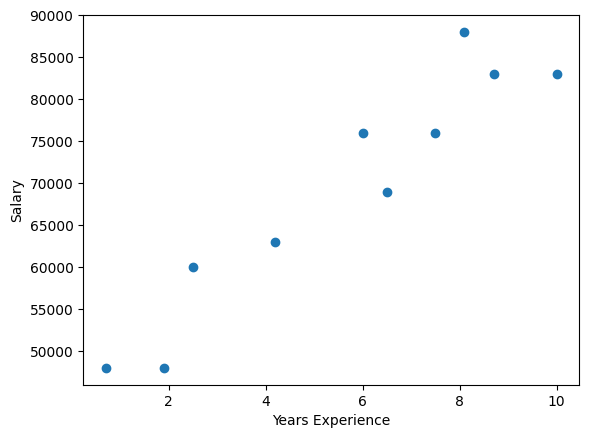

In [11]:
# Plot the data
import matplotlib.pyplot as plt

salaries = [salary for salary, _ in salaries_and_tenures]
tenures = [tenure for _, tenure in salaries_and_tenures]

plt.scatter(tenures, salaries)
plt.xlabel("Years Experience")
plt.ylabel("Salary")
plt.show()

It seems clear that people with more experience earn more. How can you turn this into a fun fact? You could calculate the average salary for each tenure:

In [12]:
# Keys are years, values are lists of the salaries for each tenure
salary_by_tenure = defaultdict(list)

for salary, tenure in salaries_and_tenures:
    salary_by_tenure[tenure].append(salary)

# Sort the keys
sorted_salary_by_tenure = dict(sorted(salary_by_tenure.items()))

print(sorted_salary_by_tenure)

{0.7: [48000], 1.9: [48000], 2.5: [60000], 4.2: [63000], 6: [76000], 6.5: [69000], 7.5: [76000], 8.1: [88000], 8.7: [83000], 10: [83000]}


In [13]:
# Keys are years, each value is average salary for that tenure
average_salary_by_tenure = {
    tenure: sum(salaries) / len(salaries)
    for tenure, salaries in salary_by_tenure.items()
}

# Sort the average_salary_by_tenure dict
sorted_average_salary_by_tenure = dict(sorted(average_salary_by_tenure.items()))

print(sorted_average_salary_by_tenure)

{0.7: 48000.0, 1.9: 48000.0, 2.5: 60000.0, 4.2: 63000.0, 6: 76000.0, 6.5: 69000.0, 7.5: 76000.0, 8.1: 88000.0, 8.7: 83000.0, 10: 83000.0}


This turns out to be not particularly useful, as none of the users have the same tenure, which means we're just reporting the individual users' salaries. Instead, we could group the tenures into ranges and calculate the average salary for each range:

In [14]:
def tenure_bucket(tenure):
    if tenure < 2:
        return "less than two"
    elif tenure < 5:
        return "between two and five"
    else:
        return "more than five"
    
# Keys are tenure buckets, values are lists of salaries for that bucket
salary_by_tenure_bucket = defaultdict(list)

for salary, tenure in salaries_and_tenures:
    bucket = tenure_bucket(tenure)
    salary_by_tenure_bucket[bucket].append(salary)

print(salary_by_tenure_bucket)


defaultdict(<class 'list'>, {'more than five': [83000, 88000, 76000, 69000, 76000, 83000], 'less than two': [48000, 48000], 'between two and five': [60000, 63000]})


In [15]:
# Keys are tenure buckets, values are average salary for that bucket
average_salary_by_bucket = {
    tenure_bucket: sum(salaries) / len(salaries)
    for tenure_bucket, salaries in salary_by_tenure_bucket.items()
}

print(average_salary_by_bucket)

{'more than five': 79166.66666666667, 'less than two': 48000.0, 'between two and five': 61500.0}


# Part 4 - Paid Accounts

Which users pay for accounts and which don’t? You notice that there seems to be a correspondence between years of experience and paid accounts:

In [16]:
yoe_and_accounts = [ (0.7, "paid"), (1.9, "unpaid"),
                     (2.5, "paid"), (4.2, "unpaid"),
                     (6.0, "unpaid"), (6.5, "unpaid"),
                     (7.5, "unpaid"), (8.1, "unpaid"),
                     (8.7, "paid"), (10, "paid") ]

# Users with very few and very many years of experience tend to pay; users with average amounts of experience don’t.

Accordingly, if you wanted to create a model — though this is definitely not enough data to base a model on — you might try to predict “paid” for users with very few and very many years of experience, and “unpaid” for users with middling amounts of experience:

In [17]:
def predict_paid_or_unpaid(years_experience):
    if years_experience < 3.0:
        return "paid"
    elif years_experience < 8.5:
        return "unpaid"
    else:
        return "paid"

Of course, we totally eyeballed the cutoffs.
With more data (and more mathematics), we could build a model predicting the likelihood that a user would pay based on his years of experience.

# Part 5 - Topics of Interest

What topics users are most interested in?

In [19]:
print(interests)

[(0, 'Hadoop'), (0, 'Big Data'), (0, 'HBase'), (0, 'Java'), (0, 'Spark'), (0, 'Storm'), (0, 'Cassandra'), (1, 'NoSQL'), (1, 'MongoDB'), (1, 'Cassandra'), (1, 'HBase'), (1, 'Postgres'), (2, 'Python'), (2, 'scikit-learn'), (2, 'scipy'), (2, 'numpy'), (2, 'statsmodels'), (2, 'pandas'), (3, 'R'), (3, 'Python'), (3, 'statistics'), (3, 'regression'), (3, 'probability'), (4, 'machine learning'), (4, 'regression'), (4, 'decision trees'), (4, 'libsvm'), (5, 'Python'), (5, 'R'), (5, 'Java'), (5, 'C++'), (5, 'Haskell'), (5, 'programming languages'), (6, 'statistics'), (6, 'probability'), (6, 'mathematics'), (6, 'theory'), (7, 'machine learning'), (7, 'scikit-learn'), (7, 'Mahout'), (7, 'neural networks'), (8, 'neural networks'), (8, 'deep learning'), (8, 'Big Data'), (8, 'artificial intelligence'), (9, 'Hadoop'), (9, 'Java'), (9, 'MapReduce'), (9, 'Big Data')]


In [21]:
words_and_counts = Counter(word
                            for user, interest in interests
                            for word in interest.lower().split())

print(words_and_counts)

Counter({'big': 3, 'data': 3, 'java': 3, 'python': 3, 'learning': 3, 'hadoop': 2, 'hbase': 2, 'cassandra': 2, 'scikit-learn': 2, 'r': 2, 'statistics': 2, 'regression': 2, 'probability': 2, 'machine': 2, 'neural': 2, 'networks': 2, 'spark': 1, 'storm': 1, 'nosql': 1, 'mongodb': 1, 'postgres': 1, 'scipy': 1, 'numpy': 1, 'statsmodels': 1, 'pandas': 1, 'decision': 1, 'trees': 1, 'libsvm': 1, 'c++': 1, 'haskell': 1, 'programming': 1, 'languages': 1, 'mathematics': 1, 'theory': 1, 'mahout': 1, 'deep': 1, 'artificial': 1, 'intelligence': 1, 'mapreduce': 1})


In [22]:
for word, count in words_and_counts.most_common():
    if count > 1:
        print(word, count)

big 3
data 3
java 3
python 3
learning 3
hadoop 2
hbase 2
cassandra 2
scikit-learn 2
r 2
statistics 2
regression 2
probability 2
machine 2
neural 2
networks 2
